# MNIST Handwritten Digit Classification with TensorFlow



## 1. Introduction and Setup



**Project overview**
> In this project, you’ll build a neural network to classify handwritten digits using the popular MNIST dataset. 

>The dataset contains 60,000 training images and 10,000 test images of digits from 0 to 9, each represented as 28x28 pixel grayscale images.

In [1]:
# importing liberaries that are needed for this project
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import keras


## 2. Loading and Preprocessing the MNIST Dataset
- Loading the MNIST dataset
- Exploring the dataset structure
- Preprocessing the data (normalization, reshaping)


In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def preprocess_dataset(images, labels, batch_size=32, shuffle=True, augment=False, flatten=False):
    # Convert to float32 and normalize
    def normalize(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Shuffle the dataset if required
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
        
    # Apply augmentation if required
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)        
        
    # flatten the dataset if required
    if flatten:
        dataset = dataset.map(lambda image, label: (tf.reshape(image, [-1]), label), num_parallel_calls=tf.data.AUTOTUNE)
        
    # Apply normalization (and flattening if required)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Augmentation function 
def augment_fn(image, label):
    # Ensure the image is in float32 format and add a channel dimension
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    
    # Random rotation (reduced probability)
    if tf.random.uniform(()) < 0.25:
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random flip left-right (reduced probability)
    if tf.random.uniform(()) < 0.25:
        image = tf.image.random_flip_left_right(image)
    
    # Random brightness adjustment (reduced range)
    image = tf.image.random_brightness(image, max_delta=0.05)
    
    # Random contrast adjustment (narrower range)
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)
    
    # Ensure pixel values are still in [0, 1] range
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    # Remove the added channel dimension
    image = tf.squeeze(image, axis=-1)
    return image, label

In [4]:
# Preprocess training and test datasets
train_dataset = preprocess_dataset(x_train, y_train, shuffle=True,batch_size=32, augment=False, flatten=True)
test_dataset = preprocess_dataset(x_test, y_test, shuffle=False, batch_size=32, augment=False, flatten=True)

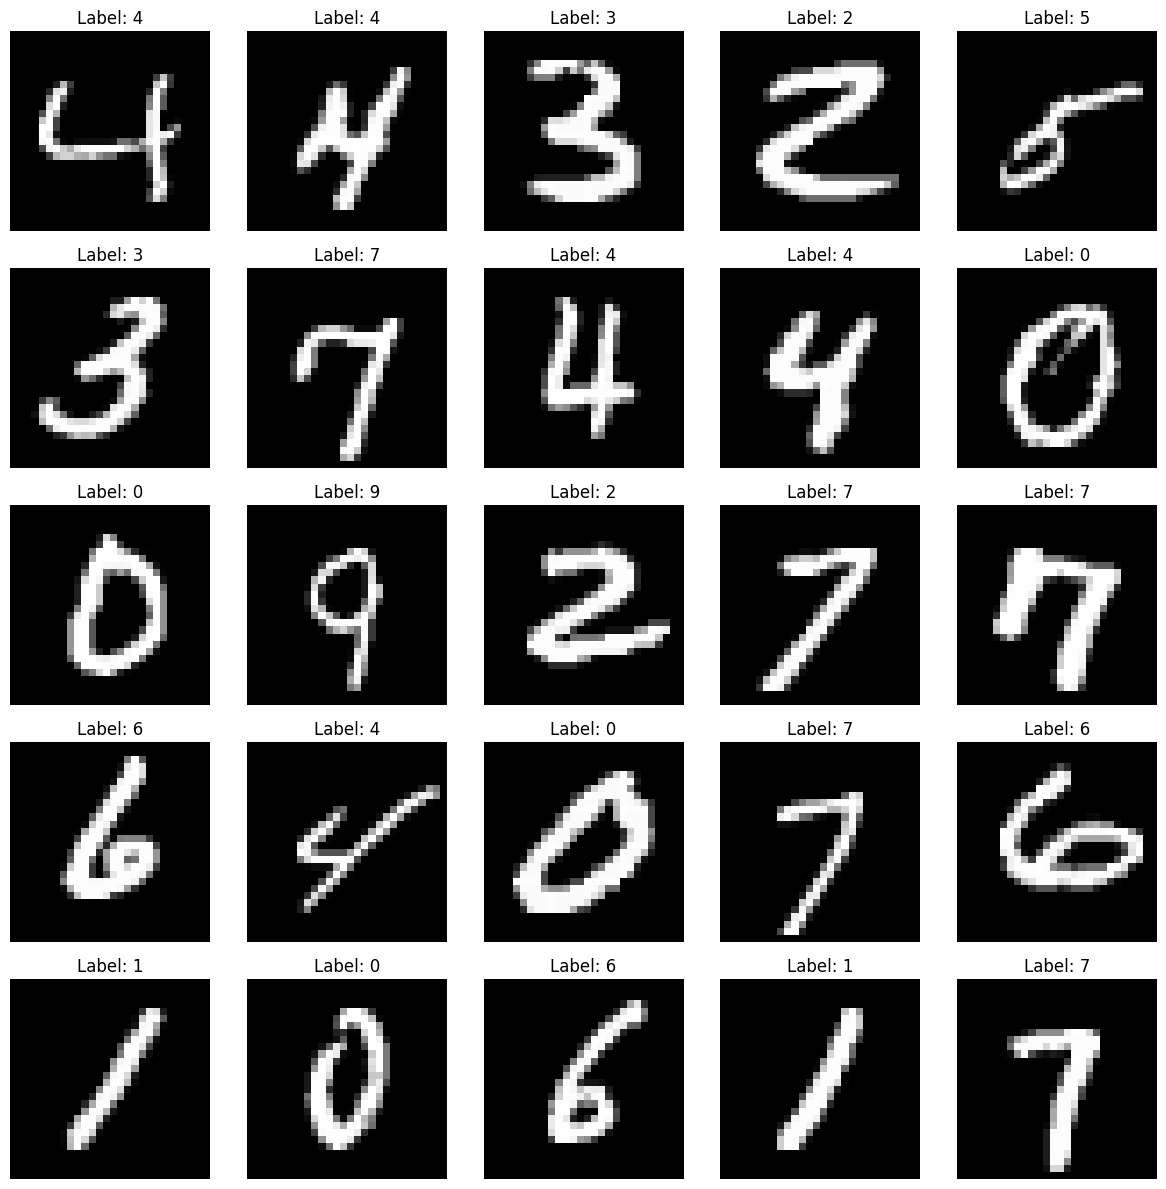

Images shape: (32, 784)
Labels shape: (32,)


In [5]:
# Visualize some samples from the train_dataset
import matplotlib.pyplot as plt

# Take a batch from the dataset
images, labels = next(iter(train_dataset))

# Plot the first 25 images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < 25:
        ax.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis('off')
plt.tight_layout()
plt.show()

# Print the shape of the images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


## 3. Building the Neural Network Model
- Defining the model architecture
- Compiling the model


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(784,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________



## 4. Training the Model
- Fitting the model to the training data
- Monitoring training progress


In [9]:
model.fit(train_dataset, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 3ms/step - loss: 0.2570 - accuracy: 0.9272
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1127 - accuracy: 0.9662
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0771 - accuracy: 0.9766
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0564 - accuracy: 0.9823
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0446 - accuracy: 0.9859


- Monitoring training progress With learning curves, tensorboard, learning rate scheduler, early stopping, model checkpointing, reduceLROnPlateau, callbacks, log_dir, plot_learning



## 5. Evaluating the Model
- Assessing model performance on the test set


In [10]:
model.evaluate(test_dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.0758 - accuracy: 0.9774


[0.07584403455257416, 0.977400004863739]


## 6. Making Predictions
- Using the model to predict on new data
- Visualizing some predictions


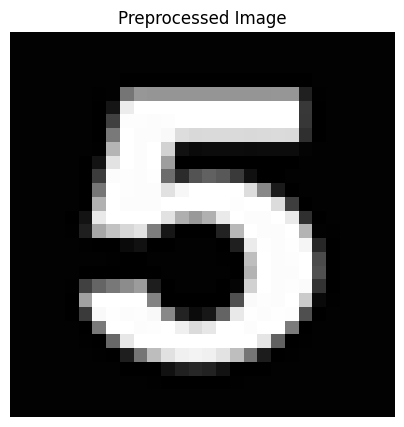

1/1 [==============================] - 0s 21ms/step
[[5.9065525e-14 1.5069992e-14 2.6012886e-15 2.3643459e-07 1.2364547e-14
  9.9999797e-01 2.0985791e-11 1.9975989e-15 2.1880391e-09 1.8131968e-06]]
Predicted digit: 5
Confidence: 100.00%


In [29]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def preprocess_and_display_image(image_path):
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The file {image_path} does not exist.")
    
    try:
        # Load the image
        img = Image.open(image_path)
    except OSError as e:
        raise OSError(f"Error opening the image file: {e}")
    
    # Convert to grayscale
    img = img.convert('L')
    
    # Resize to 28x28 pixels
    img = img.resize((28, 28))
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Invert the colors (255 - pixel_value)
    img_array = 255 - img_array
    
    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()
    
    # Convert to tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    # Normalize pixel values
    img_tensor = img_tensor / 255.0
    
    # Flatten the image
    img_tensor = tf.reshape(img_tensor, (1, 784))
    
    return img_tensor

# Usage example
image_path = r'..\TestIng Data\5.png'
try:
    preprocessed_image = preprocess_and_display_image(image_path)

    # Make prediction
    prediction = model.predict(preprocessed_image)
    print(prediction)
    predicted_digit = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    print(f"Predicted digit: {predicted_digit}")
    print(f"Confidence: {confidence:.2f}%")
except Exception as e:
    print(f"An error occurred: {e}")

## 7. Saving  the Model
- Saving the model for future use
- Deploying the model for real-world applications

In [27]:
# Define the path for saving the model
model_save_path = os.path.join("..", "Artifacts", "mnist_model.keras")

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: ..\Artifacts\mnist_model.keras


-------------